In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt

In [ ]:
def calculate_metrics_with_oe(ref, calculated, tolerance=5):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (np.ndarray): Estimated BPMs.
        tolerance (float): Precision window (default 4%).
    Returns:
        dict: Dictionary with Acc1, Acc2, Metric3, OE1, and OE2 values.
    """
    # ref_tolerance = ref * tolerance
    ref_tolerance = tolerance
    
    # Acc1: Within 4% of reference BPM
    acc1_count = np.sum(np.abs(calculated - ref) <= ref_tolerance)
    
    # Acc2: Within 4% of reference BPM, double, or half
    acc2_count = np.sum(
        # (np.abs(calculated - ref) <= ref_tolerance) |
        (np.abs(calculated - 2 * ref) <= ref_tolerance) |
        (np.abs(calculated - ref / 2) <= ref_tolerance)
    )
    
    # error_half = np.abs(calculated - ref / 2)
    # error_1x = np.abs(calculated - ref)
    # error_2x = np.abs(calculated - 2 * ref)
    
    scales = [1, 2, 0.5, 3, 1/3]

    # OE1: Overestimated BPM outside hierarchical relationships
    oe1_count = np.sum(
        (calculated > ref) &  # Overestimation
        ~np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Not within any scale
    )
    
    # OE2: Overestimated BPM within hierarchical relationships
    oe2_count = np.sum(
        (calculated > ref) &  # Overestimation
        np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Within any scale
    )
    
    total = len(ref)
    
    metrics = {
        "Acc1": (acc1_count / total) * 100,
        "Acc2": (acc2_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
    }
    return metrics


### Both Foot Onsets

In [2]:
df_feetz_p2 = pd.read_csv(f"./feetz/feet_z_peak_bi_50_150.csv")
df_feetz_p1 = pd.read_csv(f"./feetz/feet_z_peak_uni_50_150.csv")

df_feetz_z2 = pd.read_csv(f"./feetz/feet_z_zero_bi_50_150.csv")
df_feetz_z1 = pd.read_csv(f"./feetz/feet_z_zero_uni_50_150.csv")
df_feetz_bf = pd.read_csv(f"./feetz/feet_z_zero_bothfeet_50_150.csv")

ref = df_feetz_p2["bpm"].to_numpy()

tempoA_p1 = df_feetz_p1["tempoA"].to_numpy()
tempoA_p2 = df_feetz_p2["tempoA"].to_numpy()
tempoA_z1 = df_feetz_z1["tempoA"].to_numpy()
tempoA_z2 = df_feetz_z2["tempoA"].to_numpy()

tempoB_p1 = df_feetz_p1["tempoB"].to_numpy()
tempoB_p2 = df_feetz_p2["tempoB"].to_numpy()
tempoB_z1 = df_feetz_z1["tempoB"].to_numpy()
tempoB_z2 = df_feetz_z2["tempoB"].to_numpy()

tempoA_bf = df_feetz_bf["tempoA"].to_numpy()
tempoB_bf = df_feetz_bf["tempoB"].to_numpy()

In [ ]:
# Data for each experiment
experiments = {
    "peak_uni": [tempoA_p1, tempoB_p1],  
    "peak_bi": [tempoA_p2, tempoB_p2],
    "zero_uni": [tempoA_z1, tempoB_z1],
    "zero_bi": [tempoA_z2, tempoB_z2],
    "both_feet": [tempoA_bf, tempoB_bf]
}

method_labels = ["Method-1", "Method-2"]
results = {"experiment": [], "method": [],"acc1":[], "acc2": [], }

tolerance = 8
for exp_name, data in experiments.items():
    for mlabel, calculated in zip(method_labels, data):
        metrics = calculate_metrics_with_oe(ref, calculated, tolerance = tolerance)
        
        results["experiment"].append(exp_name)
        results["method"].append(mlabel)
        results["acc1"].append(metrics["acc1"])
        results["acc2"].append(metrics["acc2"])
        
results_df = pd.DataFrame(results)

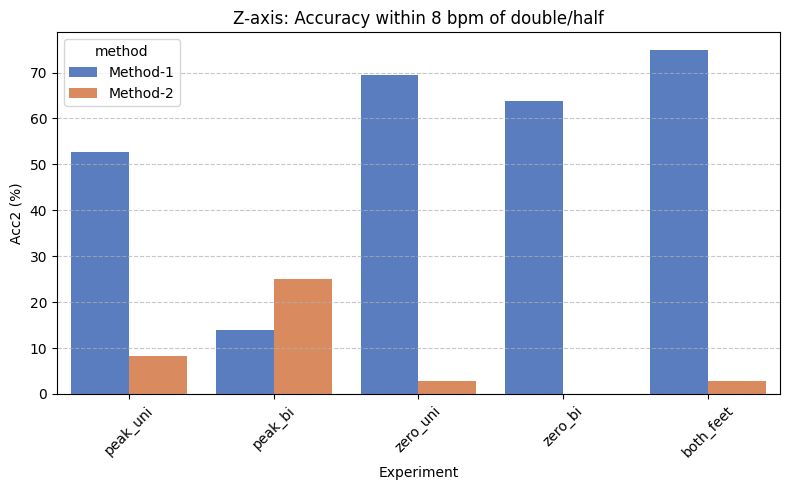

In [15]:
# Plot using Seaborn
plt.figure(figsize=(8, 5))  # Adjust figure size for better readability
sns.barplot(data=results_df, x="experiment", y="acc2", palette="muted", hue="method")

# Customize plot
plt.xlabel("Experiment")
plt.ylabel("Acc2 (%)")
plt.title(f"Z-axis: Accuracy within {tolerance} bpm of double/half")
plt.xticks(rotation=45)  # Rotate labels if necessary
# plt.ylim(0, 100)  # Set consistent y-axis limits
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save and display the plot
plt.tight_layout()
plt.savefig('./plots/feetz_acc2.png')
plt.show()